In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

  0%|          | 0/48000 [00:00<?, ?it/s]

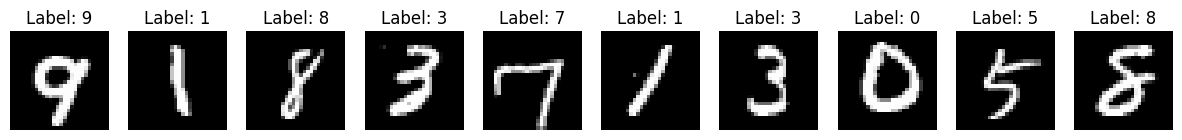

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

class SigmoidTransform(object):
    def __call__(self, tensor):
        return 1 / (1 + torch.exp(-tensor))

class TanhTransform(object):
    def __call__(self, tensor):
        return torch.tanh(tensor)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [4]:
H_DIM = 200
Z_DIM = 20
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device('cpu')

        self.encoder = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, H_DIM),
            nn.ReLU(),
        )

        self.mu = nn.Linear(H_DIM, Z_DIM)
        self.log_var = nn.Linear(H_DIM, Z_DIM)
        self.z2hid = nn.Linear(Z_DIM, H_DIM)

        self.decoder = nn.Sequential(
            nn.Linear(H_DIM, 200),
            nn.ReLU(),
            nn.Linear(200, 784),
            nn.Sigmoid(),
        )

    def to(self, device):
        self.device = device
        return super().to(device)
    
    def encode(self, x):
        encoded = self.encoder(x)
        mu, log_var = self.mu(encoded), self.log_var(encoded)
        return mu, log_var
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decode(self, z):
        hid = self.z2hid(z)
        return self.decoder(hid)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var
    
    def sample(self, num_samples, device):
        with torch.no_grad():
            z = torch.randn(num_samples, H_DIM).to(self.device)
            samples = self.decoder(z)
            return samples

In [46]:
def loss_fn(recon_x, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction="sum")
    # recon_loss = F.mse_loss(recon_x, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kld

def train(
        model,
        train_set,
        val_set,
        optimizer,
        n_epochs,
        batch_size,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        train_set.apply_transform()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, _) in loop:
            x = x.view(-1, 784)
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1])

            decoded, mu, log_var = model(x)

            loss = loss_fn(decoded, x, mu, log_var)
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss / len(train_set))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            for x, _ in val_loader:
                x = x.view(-1, 784)
                decoded, mu, log_var = model(x)

                loss = loss_fn(decoded, x, mu, log_var)
                val_loss += loss.item()

            val_losses.append(val_loss / len(val_set))
        
    return train_losses, val_losses

In [47]:
torch.manual_seed(42)
model = VAE().to(device)
x = torch.randn(6, 784).to(device)
x_hat, mu, log_var = model(x)
loss = loss_fn(x_hat, x, mu, log_var)
loss

tensor(3272.9026, device='cuda:0', grad_fn=<AddBackward0>)

In [48]:
LR = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
EPOCHS = 30
BATCH_SIZE = 32

train_losses, val_losses = train(model, train_set, val_set, optimizer, EPOCHS, BATCH_SIZE)

KeyboardInterrupt: 

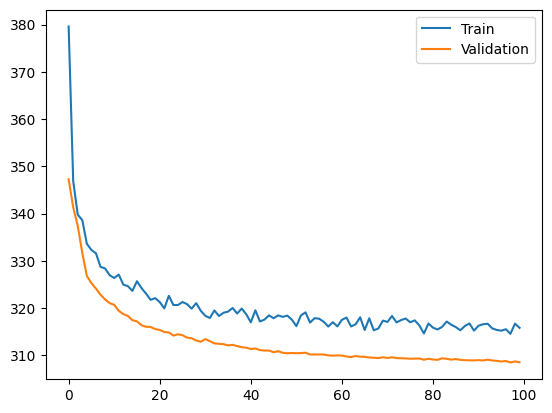

In [36]:
# Plot losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.show()

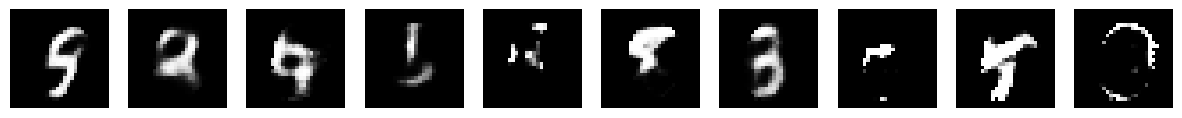

In [46]:
images = model.sample(10, device)
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

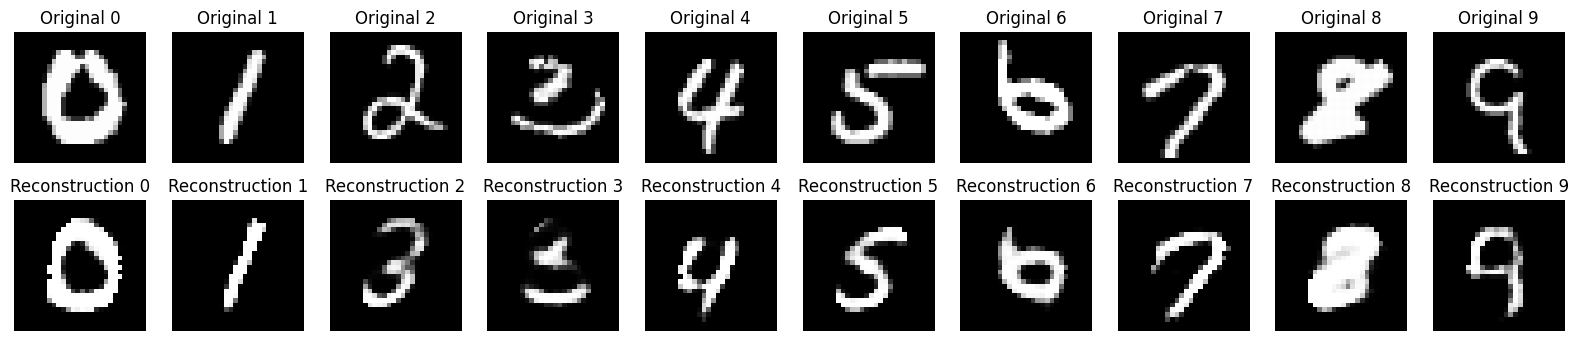

In [47]:
# Collect 1 image per class
images = {}
while len(images) < 10:
    idx = torch.randint(0, len(test_set), (1,)).item()
    x, y = test_set[idx]
    if y not in images:
        images[y.item()] = x

# Reconstruct images
reconstructions = {}
for y, x in images.items():
    x_hat, _, _ = model(x.unsqueeze(0))
    reconstructions[y] = x_hat.squeeze(0)

# Plot images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].cpu().detach().numpy().squeeze(), cmap='gray')
    axs[0, i].set_title(f'Original {i}')
    axs[1, i].set_title(f'Reconstruction {i}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
plt.show()